<a href="https://colab.research.google.com/github/tmdcks1103/Machine-Learning-Programming/blob/main/10%EC%A3%BC%EC%B0%A8/simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple CNN

In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# 2. 데이터 로드 함수 정의
# 텍스트 파일을 읽어 Numpy 배열로 반환
def load_file(filepath):
    # 공백으로 분리된 텍스트 파일을 로드
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [27]:
# 여러 파일(x, y, z축 데이터 등)을 3D Numpy 배열로 묶는 함수
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # dstack을 사용하여 (샘플, 타임스텝, 피처) 형태의 3D 배열 생성
    # (샘플 수, 128, 9) 형태가 됨
    loaded = np.dstack(loaded)
    return loaded

In [28]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + '/' + group + '/Inertial Signals/'
    # 9개 축(total_acc 3축, body_acc 3축, body_gyro 3축) 파일 이름 리스트 생성
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

    # 9개 피처 데이터를 (샘플, 128, 9) 형태로 로드
    X = load_group(filenames, filepath)
    # 정답 레이블(y) 데이터 로드
    y = load_file(prefix + '/' + group + '/y_'+group+'.txt')
    return X, y

In [29]:
# 전체 데이터셋(train, test)을 로드하고 전처리하는 메인 함수
def load_dataset(prefix=''):
    # 훈련 데이터 로드
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/10주차/UCI HAR Dataset')
    # 테스트 데이터 로드
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/10주차/UCI HAR Dataset')

    # 레이블 값 조정 (1~6 -> 0~5). (컴퓨터는 0부터 인덱싱)
    trainy = trainy - 1
    testy = testy - 1
    # 레이블을 원-핫 인코딩 (e.g., 2 -> [0,0,1,0,0,0])
    # 다중 클래스 분류의 'categorical_crossentropy' 손실 함수를 사용하기 위함
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    # 로드된 데이터의 shape(형태) 출력
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [30]:
# 3. 데이터 로드 실행
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()



/tmp/ipython-input-1063860516.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1063860516.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1063860516.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1063860516.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


/tmp/ipython-input-1063860516.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [31]:
# 4. 훈련/검증 데이터 분리
from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [32]:
# 5. 모델 파라미터 설정
# 모델의 입력 형태(타임스텝, 피처 수)와 출력(클래스 수)을 변수로 정의
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [33]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical

# CNN 모델 아키텍처 정의 (Keras Functional API 사용)
## Level_1 (첫 번째 병렬 블록)
# 4개의 병렬 입력을 정의 (동일한 데이터가 4갈래로 들어감)
inputs1_1= Input(shape=(n_timesteps,n_features)) ## (None, 128, 9)
inputs1_2= Input(shape=(n_timesteps,n_features))
inputs1_3= Input(shape=(n_timesteps,n_features))
inputs1_4= Input(shape=(n_timesteps,n_features))

# 4개의 서로 다른 커널 크기(3, 5, 7, 9)를 가진 Conv1D 레이어
# 각 커널은 서로 다른 길이의 시간적 패턴을 감지
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1)
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)

# 4개 브랜치에서 나온 특징 맵(feature map)을 시간 축(axis=1) 기준으로 하나로 합침
merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)

# Max Pooling을 통해 특징 맵의 크기를 줄여(다운샘플링) 중요한 특징만 추출
pool_1=MaxPooling1D(pool_size=5)(merged_1)

In [34]:
## Level_2 (두 번째 병렬 블록)
# Level 1의 출력을 받아 동일한 구조 반복 (필터 수 64)
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1)

# 4개 브랜치 결합
merged_2 = concatenate([conv2_1,conv2_2,conv2_3,conv2_4],axis=1)
# Max Pooling
pool_2=MaxPooling1D(pool_size=5)(merged_2)

In [35]:
## Level_3 (세 번째 병렬 블록)
# Level 2의 출력을 받아 동일한 구조 반복 (필터 수 32)
conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool_2)
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(pool_2)
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu')(pool_2)
conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu')(pool_2)
# 4개 브랜치 결합
merged_3 = concatenate([conv3_1,conv3_2,conv3_3,conv3_4],axis=1)
# Max Pooling
pool_3=MaxPooling1D(pool_size=5)(merged_3)

In [36]:
## 분류기 (Classifier Head)
# 3D 형태의 최종 특징 맵을 1D 벡터로 평탄화(Flatten)
flat_cnn=Flatten()(pool_3)

In [37]:
# 완전 연결 레이어 (Dense Layer)로 특징들을 조합
dense = Dense(512, activation='relu')(flat_cnn)
# 최종 출력 레이어 (6개 클래스 분류, softmax 활성화 함수로 확률 출력)
outputs = Dense(n_outputs, activation='softmax')(dense)

In [38]:
## 모델 정의
# 4개의 입력을 받아 1개의 출력을 내는 Keras 모델로 최종 정의
cnn3_model = Model([inputs1_1, inputs1_2, inputs1_3,inputs1_4], outputs)

In [39]:
# 모델 컴파일
# 손실 함수: categorical_crossentropy (다중 분류용)
# 옵티마이저: adam (보편적으로 성능이 좋은 옵티마이저)
# 평가 지표: accuracy (정확도)
cnn3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 모델 구조 요약 출력
cnn3_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 126, 128)  │      3,584 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 124, 128)  │      5,888 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 122, 128)  │      8,192 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 120, 128)  │     10,496 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 492, 128)  │          0 │ conv1d_12[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_13[0][0],  │
│                     │                   │            │ conv1d_14[0][0],  │
│                     │                   │            │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 98, 128)   │          0 │ concatenate_3[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 96, 64)    │     24,640 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 94, 64)    │     41,024 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 92, 64)    │     57,408 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 90, 64)    │     73,792 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 372, 64)   │          0 │ conv1d_16[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_17[0][0],  │
│                     │                   │            │ conv1d_18[0][0],  │
│                     │                   │            │ conv1d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 74, 64)    │          0 │ concatenate_4[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 72, 32)    │      6,176 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 70, 32)    │     10,272 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 68, 32)    │     14,368 │ max_pooling1d_4[

 Total params: 1,179,014 (4.50 MB)

 Trainable params: 1,179,014 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# 모델 학습

# 4개의 입력(inputs1_1 ~ inputs1_4)에 동일한 X_train을 4번 리스트로 묶어 전달
model_history=cnn3_model.fit(x=[X_train,X_train,X_train,X_train],
                             y=y_train_one_hot,
                             epochs=30,          # 전체 데이터셋 30번 반복 학습
                             batch_size=32,      # 한 번에 32개 샘플씩 학습
                             validation_split=0.1) # 훈련 데이터 중 10%를 검증용으로 사용

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.7398 - loss: 0.6406 - val_accuracy: 0.9474 - val_loss: 0.1425
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9565 - loss: 0.1112 - val_accuracy: 0.9474 - val_loss: 0.1181
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9558 - loss: 0.1062 - val_accuracy: 0.9593 - val_loss: 0.0987
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9591 - loss: 0.1018 - val_accuracy: 0.9576 - val_loss: 0.0944
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9587 - loss: 0.1170 - val_accuracy: 0.9525 - val_loss: 0.0940
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9614 - loss: 0.0964 - val_accuracy: 0.8455 - val_loss: 0.5456
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9247 - loss: 0.2624 - val_accuracy: 0.9626 - val_loss: 0.0904
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9597 - loss: 0.0919 - val_accuracy: 

In [41]:
# 학습 과정 시각화 (손실)
import matplotlib.pyplot as plt
import seaborn as sns

# 학습 기록에서 훈련 손실(loss)과 검증 손실(val_loss)을 가져옴
loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)

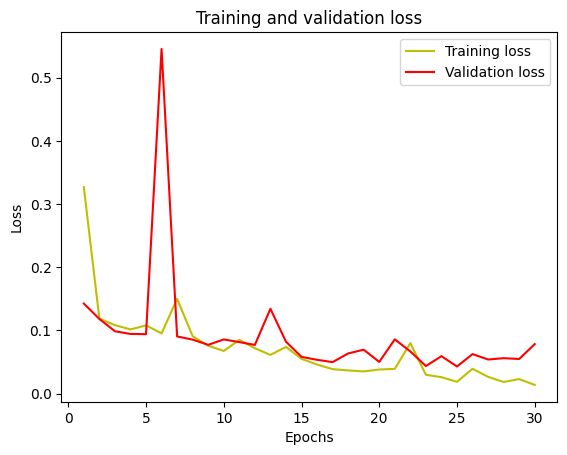

In [42]:
# 손실 그래프 그리기
plt.plot(epochs, loss, 'y', label='Training loss')      # 훈련 손실 (노란색)
plt.plot(epochs, val_loss, 'r', label='Validation loss') # 검증 손실 (빨간색)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

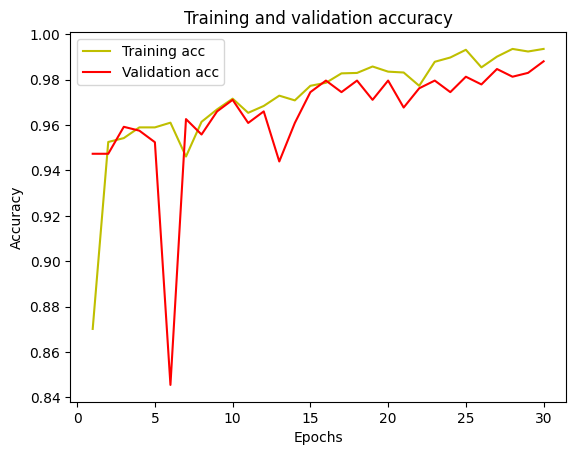

In [43]:
# 학습 과정 시각화 (정확도)
# 학습 기록에서 훈련 정확도(accuracy)와 검증 정확도(val_accuracy)를 가져옴
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']

# 정확도 그래프 그리기
plt.plot(epochs, acc, 'y', label='Training acc')      # 훈련 정확도 (노란색)
plt.plot(epochs, val_acc, 'r', label='Validation acc') # 검증 정확도 (빨간색)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
=== 혼동 행렬 (Confusion Matrix) ===
[[475   3  18   0   0   0]
 [  1 466   4   0   0   0]
 [  0   4 416   0   0   0]
 [  0   8   0 390  93   0]
 [  0   1   0  25 506   0]
 [  0   3   0   0   0 534]]

=== 최종 정확도 (Accuracy) ===
0.9457074991516796

=== 분류 리포트 (Classification Report) ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       496
           1       0.96      0.99      0.97       471
           2       0.95      0.99      0.97       420
           3       0.94      0.79      0.86       491
           4       0.84      0.95      0.89       532
           5       1.00      0.99      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947


=== 혼동 행렬 시각화 ===


<Axes: >

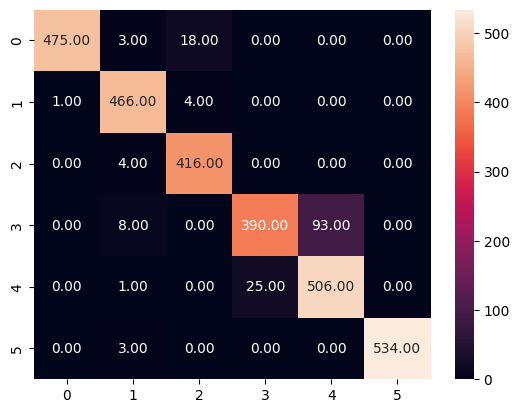

In [44]:
# 모델 최종 평가 (테스트 데이터)
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# 학습에 전혀 사용되지 않은 'testX' 데이터로 예측 수행
# (학습 때와 마찬가지로 4번 동일하게 입력)
pred=cnn3_model.predict([testX,testX,testX,testX])
# 예측 결과(확률 배열)를 가장 높은 확률의 클래스 인덱스(0~5)로 변환
pred=np.argmax(pred, axis=-1)

# 혼동 행렬(Confusion Matrix) 생성 (실제값 testy vs 예측값 pred)
cm=confusion_matrix(testy,pred)
print("=== 혼동 행렬 (Confusion Matrix) ===")
print(cm)

# 최종 정확도 출력
print("\n=== 최종 정확도 (Accuracy) ===")
print(accuracy_score(testy,pred))

# 클래스별 정밀도(precision), 재현율(recall), f1-score 리포트 출력
print("\n=== 분류 리포트 (Classification Report) ===")
print(classification_report(testy,pred))

# 혼동 행렬 시각화
print("\n=== 혼동 행렬 시각화 ===")
sns.heatmap(cm, annot=True, fmt = '.2f') # 'fmt'는 소수점 표기

# 다중 커널 CNN 모델